In [1]:
import numpy as np
import pandas as pd
from skbio.stats.composition import clr
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.diversity.alpha import shannon
from scipy.stats import pearsonr
from scipy.stats import mannwhitneyu
sns.set(rc={'axes.facecolor':'white', 
            'figure.facecolor':'white', 
            'axes.edgecolor':'black', 
            'grid.color': 'black'
            }, 
       font_scale=2)

def rescale(xx):
    return(xx/xx.sum(axis=1)[:, np.newaxis] )

def add_15_percent_to_top_ylim(ax):
    ylim=ax.get_ylim() 
    ax.set_ylim( ylim[0], ylim[1] + ( ylim[1] - ylim[0] ) * .15)
    return(None)



In [2]:
def make_shannon_plot(df, 
                      md
                     ):
    sh_alphas = [shannon(x) for x in df.values]
    md['Shannon_diversities'] = sh_alphas

    mw = mannwhitneyu( *[md.loc[md.grouping==a].Shannon_diversities
                       for a in md.grouping.unique()]
                       )

    plt.figure(figsize=(12 * .3,7))
    if df.shape[0]<=100:
        ax=sns.boxplot(x = md.grouping, 
                    y=md.Shannon_diversities, 
                    fliersize=0
                   )
    else:
        ax=sns.boxplot(x = md.grouping, 
                    y=md.Shannon_diversities, 
                   )
        
    if df.shape[0]<=100: # make swarmplot if we don't have too many points
        sns.swarmplot(x = md.grouping, 
                      y=md.Shannon_diversities, 
                      size=5, 
                      color='black', 
                      ax=ax
                      )

    plt.ylabel('Shannon diversity')
    plt.xlabel(None)
    plt.title('Mann Whitney U p = {:.1e}\n'.format(mw.pvalue))
    plt.xticks(rotation=90)
    return(ax)



In [3]:
def make_ra_feature_plot(df, 
                         md, 
                         val,
                         pseudocount=0
                         ):

    val_ = np.where(df.columns == val)[0][0]
    X_ra = rescale(df.values+pseudocount) 
    md['ra'] = X_ra[:, val_]

    try:
        mw = mannwhitneyu( *[md.loc[md.grouping==a].ra
                             for a in md.grouping.unique()]
                             )
        pval=mw.pvalue
    except:
        pval = 1000
        
    plt.figure(figsize=(12 * .3,7))

    if df.shape[0]<=100: 
        ax = sns.boxplot(x = md.grouping, 
                         y=X_ra[:,val_], 
                         fliersize=0
                         )
    else:
        ax = sns.boxplot(x = md.grouping, 
                         y=X_ra[:,val_], 
                         )

    if df.shape[0]<=100: # make swarmplot if we don't have too many points
        sns.swarmplot(x = md.grouping, 
                      y=X_ra[:,val_], 
                      size=5, 
                      color='black', 
                      ax=ax
                      )
    plt.ylabel("{}'s relative abundance".format(val.split('g__')[-1]))
    plt.xlabel(None)
    plt.title( 'Mann Whitney U p = {:.1e}\n'.format(pval) )
    plt.xticks(rotation=90)
    return(ax)



def make_clr_feature_plot(df, 
                          md, 
                          val,
                          pseudocount='minimal_value'
                          ):

    val_ = np.where(df.columns == val)[0][0]
    
    if pseudocount =='minimal_value':
        val_ = np.where(df.columns == val)[0][0]
        rsc_df = rescale(df.values)
        X_clr = clr(rsc_df + 10**np.floor(np.log10(rsc_df[rsc_df != 0].min())))
    elif pseudocount=='one':
         X_clr = clr(rescale(1 + df.values)  )
    else:
        Raise(ValueError('pseudocount must be either `minimal_value` or `one`'))
    
    md['clre'] = X_clr[:, val_]


    mw = mannwhitneyu( *[md.loc[md.grouping==a].clre
                       for a in md.grouping.unique()]
                       )
    plt.figure(figsize=(12 * .3,7))
    if df.shape[0]<=100: 
        ax = sns.boxplot(x = md.grouping, 
                         y=X_clr[:,val_], 
                         fliersize=0
                         )
        
    else:
        ax = sns.boxplot(x = md.grouping, 
                         y=X_clr[:,val_], 
                         )

    if df.shape[0]<=100: # make swarmplot if we don't have too many points
        sns.swarmplot(x = md.grouping, 
                      y=X_clr[:,val_], 
                      size=5, 
                      color='black', 
                      ax=ax
                      )
    plt.ylabel("{}'s centered log ratio".format(val.split('g__')[-1]))
    plt.xlabel(None)
    plt.title( 'Mann Whitney U p = {:.1e}\n'.format(mw.pvalue) )
    plt.xticks(rotation=90)
    return(ax)




In [4]:
pseudo_list = list(np.logspace(-8, -1, 8))

In [5]:
def make_pseudocount_boxplot(df,
                             md, 
                             xaxis_name, 
                             val, 
                             pval_thresh=1e-3, 
                             seed=0):
    
    np.random.seed(seed)
    rsc_df = rescale(df.values)
    y=md.grouping.values

    pseudo_list = np.logspace(-8, -1, 8)#np.logspace(-14, 3, 18)

    vary_pseudo= pd.DataFrame( {pseudo_ : clr( rescale( pseudo_ + rsc_df ) )[:, -1] 
                                        for pseudo_ in pseudo_list } ).T\
                        .reset_index()

    vary_pseudo.columns = ['pseudocount'] + list(y)
    vary_pseudo = vary_pseudo.melt(id_vars='pseudocount')
    vary_pseudo['pseudocount'] = vary_pseudo['pseudocount'].astype(str)
    vary_pseudo[xaxis_name] = vary_pseudo['variable']
    
    vary_pseudo['pseudocount'] = vary_pseudo['pseudocount'].astype(float)
    plt.figure(figsize=(14,8))
#     plt.semilogx(base=10)
    
    if df.shape[0] >= 100:
        flierprops = dict(marker='o', 
                          markersize=5,  
                          markeredgecolor='black'
                          )

        ax=sns.boxplot(
                       x='pseudocount', 
                       y='value', 
                       hue=xaxis_name, 
                       data=vary_pseudo, 
                       flierprops=flierprops
                       )

        for i,artist in enumerate(ax.artists):
            col = artist.get_facecolor()

            # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour as above
            for j in [i*6+5]:#range(i*6,i*6+6):
                line = ax.lines[j]
                line.set_color(col)
                line.set_mfc(col)
                line.set_mec(col)
    else:
        ax=sns.boxplot(
                       x='pseudocount', 
                       y='value', 
                       hue=xaxis_name, 
                       data=vary_pseudo, 
                       fliersize=0
                       )
        
        sns.swarmplot(
                       x='pseudocount', 
                       y='value', 
                       hue=xaxis_name, 
                       data=vary_pseudo, 
                       dodge=True,
                       s=2.5, 
                       edgecolor='black',
                       linewidth=.25,
                       ax=ax
                       )
    
    
#     vary_pseudo['pseudocount'] = vary_pseudo['pseudocount'].astype(str)

    sig_df = pd.DataFrame({pseudo_ :\
                mannwhitneyu(
                         vary_pseudo.loc[
                             (vary_pseudo[xaxis_name]==vary_pseudo[xaxis_name]\
                                      .value_counts().index.values[0])&\
                            (vary_pseudo['pseudocount']==pseudo_)].value, 
                         vary_pseudo.loc[
                             (vary_pseudo[xaxis_name]==vary_pseudo[xaxis_name]\
                                      .value_counts().index.values[1])&\
                            (vary_pseudo['pseudocount']==pseudo_)].value
                            ).pvalue
                    for pseudo_ in pseudo_list
                      }, index=[0])
    
    sig_df=sig_df.T.reset_index()
    sig_df.columns=['pseudocount', 'pvalue']
    sig_df['is_sig'] = sig_df.pvalue < pval_thresh
    sig_df['y_val'] = vary_pseudo.value.min() * 1.3
    sig_df['pseudocount'] = sig_df['pseudocount'].astype(float)
    
    print(sig_df)
    
    if sum(sig_df.is_sig)>0:
        sns.swarmplot(x='pseudocount',
                      y='y_val', 
                      data = sig_df.loc[sig_df.is_sig].reset_index(), 
                      marker='+',
                      size= 25/2, 
                      order=sig_df.pseudocount.unique(),
                      ax=ax,
                      color='red',
                      linewidth=3.5/2
                      )

        sns.swarmplot(x='pseudocount', 
                      y='y_val', 
                      data = sig_df.loc[sig_df.is_sig].reset_index(), 
                      marker='x',
                      size= 18.5/2,
                      order=sig_df.pseudocount.unique(),
                      ax=ax,
                      color='red',
                      linewidth=3.5/2,
                      )



    plt.xticks(ticks=range(len(pseudo_list)), 
               labels=pseudo_list, 
               rotation=90)
    # plt.yscale('symlog', linthresh=1e-5)

    # plt.yticks([])
    plt.ylabel('CLR of {}'.format(val.split('g__')[-1]))
    plt.xlabel('Pseudocount (added in relative abundance space)')
    # ax.legend(handles[:2], labels[:2], loc='lower right')
    plt.title('CLR introduce tumor-associated differences in TCGA sparse features\n'+\
              'across all pseudocount values')
    return(ax)

## their fig 2

In [6]:
df = pd.read_csv('Kraken-TCGA-Raw-Data-17625-Samples.csv', index_col=0)
md = pd.read_csv('Metadata-TCGA-All-18116-Samples.csv', index_col=0).loc[df.index]

df=df.loc[df.index.isin(md.index)]
md=md.loc[md.index.isin(df.index)].loc[df.index]


cols = pd.read_csv('Kraken-TCGA-Voom-SNM-Most-Stringent-Filtering-Data.csv', 
            index_col=0, nrows=1).columns
df = df.loc[:, cols[cols.str.contains('contaminant')==False]]
df_vsnm=pd.read_csv('Kraken-TCGA-Voom-SNM-Most-Stringent-Filtering-Data.csv', 
            index_col=0).loc[md.index]

md['grouping'] = md.disease_type == 'Adrenocortical Carcinoma'
xaxis_name = 'Adrenocortical Carcinoma'

save_path = 'supp-plots/Fig-S2c'
val = df.columns[df.columns.str.contains('Hepandensovirus')].values[0]

    pseudocount        pvalue  is_sig     y_val
0  1.000000e-08  1.606943e-13    True -8.433946
1  1.000000e-07  2.762974e-11    True -8.433946
2  1.000000e-06  1.324946e-07    True -8.433946
3  1.000000e-05  4.895620e-03    True -8.433946
4  1.000000e-04  3.701122e-01   False -8.433946
5  1.000000e-03  9.085277e-02   False -8.433946
6  1.000000e-02  1.833027e-03    True -8.433946
7  1.000000e-01  1.674272e-04    True -8.433946
    pseudocount        pvalue  is_sig     y_val
0  1.000000e-08  1.606943e-13    True -8.433946
1  1.000000e-07  2.762974e-11    True -8.433946
2  1.000000e-06  1.324946e-07    True -8.433946
3  1.000000e-05  4.895620e-03    True -8.433946
4  1.000000e-04  3.701122e-01   False -8.433946
5  1.000000e-03  9.085277e-02   False -8.433946
6  1.000000e-02  1.833027e-03    True -8.433946
7  1.000000e-01  1.674272e-04    True -8.433946


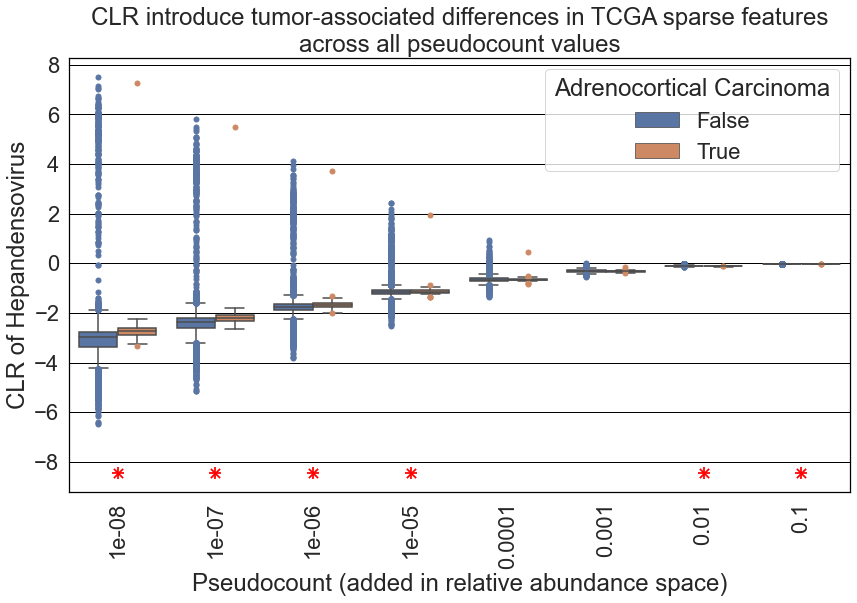

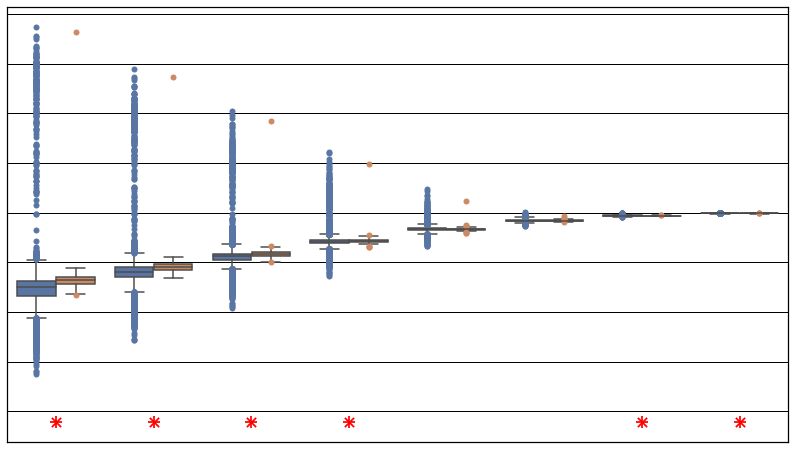

In [7]:
ax=make_pseudocount_boxplot(df,
                         md, 
                         xaxis_name, 
                         val, 
                         pval_thresh=0.01
                         )

plt.savefig(save_path+'.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
            )

ax=make_pseudocount_boxplot(df,
                         md, 
                         xaxis_name, 
                         val, 
                         pval_thresh=0.01
                         )

ax.get_legend().remove()
ax.set(
       yticklabels=[], 
       xticklabels=[])
plt.xlabel(None)
plt.ylabel(None)
plt.title(None)
plt.savefig(save_path+'-no-axes.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
            )

## their fig 3

In [8]:
df = pd.read_csv('Kraken-TCGA-Raw-Data-17625-Samples.csv', index_col=0)
md=pd.read_csv('Metadata-TCGA-Kraken-17625-Samples.csv', index_col=0).loc[df.index]
md=md.loc[md.experimental_strategy=='WGS']
md=md.loc[(md.sample_type!='Blood Derived Normal')&\
          (md.disease_type=='Kidney Chromophobe')
         ]

df=df.loc[df.index.isin(md.index)]
md=md.loc[md.index.isin(df.index)].loc[df.index]

md = md.sort_values('sample_type', ascending=False)
df=df.loc[md.index]

cols=  pd.read_csv('Kraken-TCGA-Voom-SNM-All-Putative-Contaminants-Removed-Data.csv', 
            index_col=0, nrows=1).columns
df = df.loc[:, cols[cols.str.contains('contaminant')==False]]

md['grouping'] = md.sample_type
save_path = 'supp-plots/Fig-S2d'
val = df.columns[df.columns.str.contains('Thiorhodospira')].values[0]

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 14.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 24.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 38.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 63.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/george/op

    pseudocount        pvalue  is_sig     y_val
0  1.000000e-08  5.336880e-11    True -5.663477
1  1.000000e-07  3.875673e-07    True -5.663477
2  1.000000e-06  4.820889e-03    True -5.663477
3  1.000000e-05  1.960575e-02   False -5.663477
4  1.000000e-04  6.778938e-03    True -5.663477
5  1.000000e-03  4.290620e-03    True -5.663477
6  1.000000e-02  9.013268e-03    True -5.663477
7  1.000000e-01  3.603059e-02   False -5.663477


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 14.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 24.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 38.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 63.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/george/op

    pseudocount        pvalue  is_sig     y_val
0  1.000000e-08  5.336880e-11    True -5.663477
1  1.000000e-07  3.875673e-07    True -5.663477
2  1.000000e-06  4.820889e-03    True -5.663477
3  1.000000e-05  1.960575e-02   False -5.663477
4  1.000000e-04  6.778938e-03    True -5.663477
5  1.000000e-03  4.290620e-03    True -5.663477
6  1.000000e-02  9.013268e-03    True -5.663477
7  1.000000e-01  3.603059e-02   False -5.663477


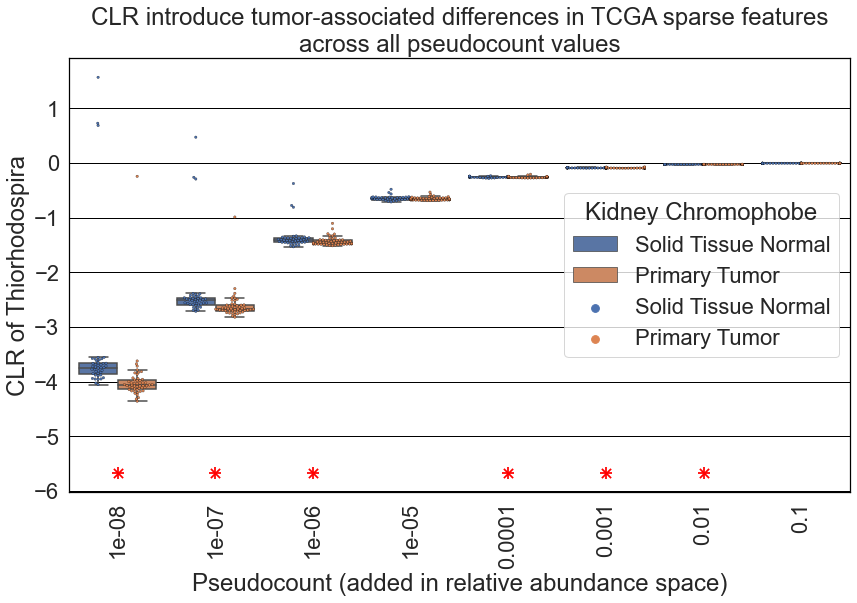

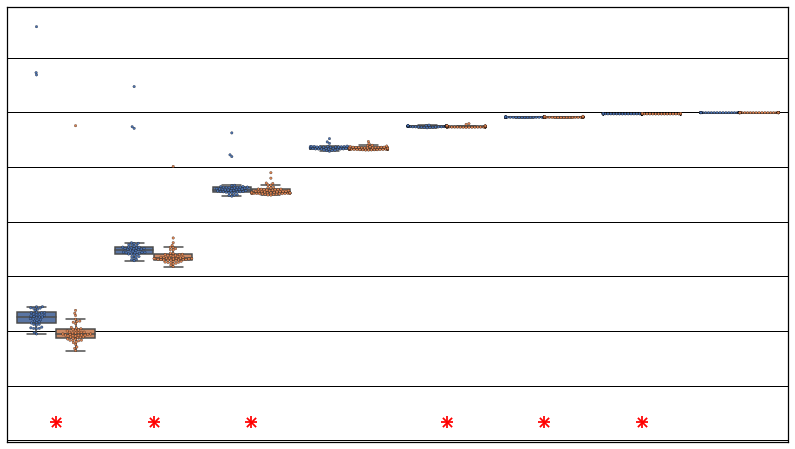

In [9]:
ax=make_pseudocount_boxplot(df,
                         md, 
                         'Kidney Chromophobe', 
                         val, 
                         pval_thresh=0.01
                         )


plt.savefig(save_path+'.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
            )

ax=make_pseudocount_boxplot(df,
                         md, 
                         'Kidney Chromophobe', 
                         val, 
                         pval_thresh=0.01
                         )


ax.get_legend().remove()
ax.set(
       yticklabels=[], 
       xticklabels=[])
plt.xlabel(None)
plt.ylabel(None)
plt.title(None)
plt.savefig(save_path+'-no-axes.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
            )

In [10]:


# make_pseudocount_boxplot(df,
#                          md, 
#                          'Kidney Chromophobe', 
#                          val, 
#                          pval_thresh=0.01
#                          )


In [11]:
# plt.semilogx(base=10)

## fig 4

In [12]:
df = pd.read_csv('Kraken-TCGA-Raw-Data-17625-Samples.csv', index_col=0)
md = pd.read_csv('Metadata-TCGA-All-18116-Samples.csv', index_col=0).loc[df.index]
md = md.loc[ md.sample_type == 'Primary Tumor' ]
df=df.loc[df.index.isin(md.index)]
md=md.loc[md.index.isin(df.index)].loc[df.index]

cols=  pd.read_csv('Kraken-TCGA-Voom-SNM-All-Putative-Contaminants-Removed-Data.csv', 
            index_col=0, nrows=1).columns
df = df.loc[:, cols[cols.str.contains('contaminant')==False]]

md['grouping'] = md.disease_type=='Lung Squamous Cell Carcinoma'
xaxis_name = 'Lung Squamous Cell Carcinoma'

# save_path = 'tcga_plots/Fig-4-Lung-Squamous-Cell-Carcinoma-Nitrospira'
val = 'k__Bacteria.p__Nitrospirae.c__Nitrospira.o__Nitrospirales.f__Nitrospiraceae.g__Nitrospira'



save_path = 'supp-plots/Fig-S2e'


    pseudocount        pvalue  is_sig      y_val
0  1.000000e-08  1.249385e-01   False -10.416885
1  1.000000e-07  3.231438e-04    True -10.416885
2  1.000000e-06  3.310136e-13    True -10.416885
3  1.000000e-05  1.998925e-22    True -10.416885
4  1.000000e-04  1.536145e-28    True -10.416885
5  1.000000e-03  1.022855e-33    True -10.416885
6  1.000000e-02  3.759650e-33    True -10.416885
7  1.000000e-01  2.043754e-30    True -10.416885
    pseudocount        pvalue  is_sig      y_val
0  1.000000e-08  1.249385e-01   False -10.416885
1  1.000000e-07  3.231438e-04    True -10.416885
2  1.000000e-06  3.310136e-13    True -10.416885
3  1.000000e-05  1.998925e-22    True -10.416885
4  1.000000e-04  1.536145e-28    True -10.416885
5  1.000000e-03  1.022855e-33    True -10.416885
6  1.000000e-02  3.759650e-33    True -10.416885
7  1.000000e-01  2.043754e-30    True -10.416885


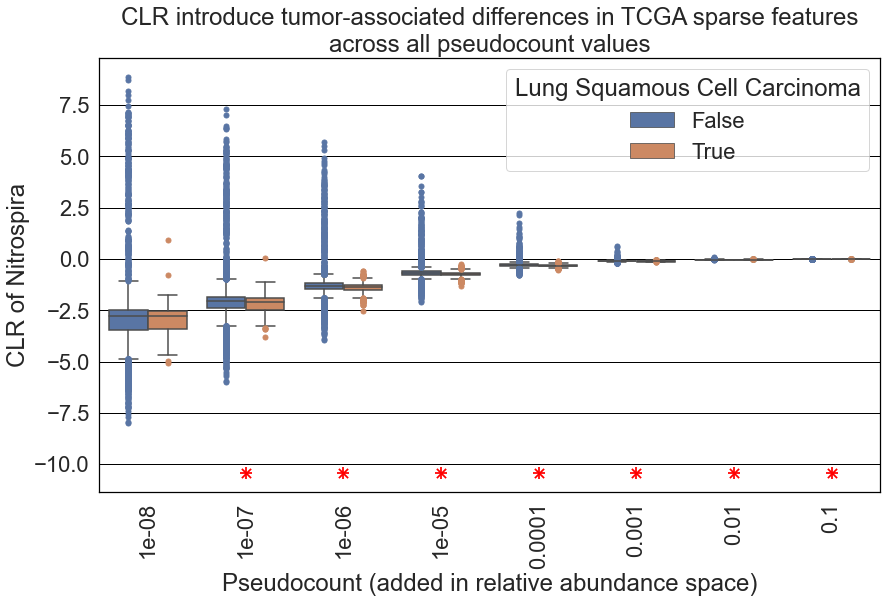

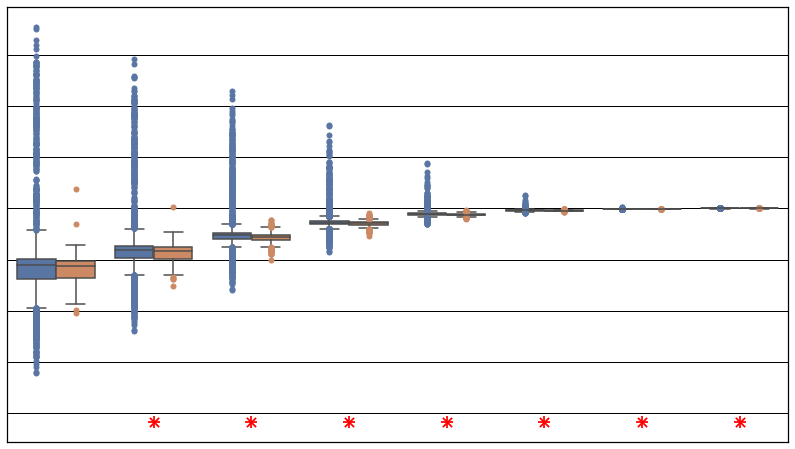

In [13]:
ax=make_pseudocount_boxplot(df,
                         md, 
                         xaxis_name,
                         val, 
                         pval_thresh=0.01)


plt.savefig(save_path+'.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
            )

ax=make_pseudocount_boxplot(df,
                         md, 
                         xaxis_name,
                         val, 
                         pval_thresh=0.01)


ax.get_legend().remove()
ax.set(
       yticklabels=[], 
       xticklabels=[])
plt.xlabel(None)
plt.ylabel(None)
plt.title(None)
plt.savefig(save_path+'-no-axes.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
            )

    pseudocount        pvalue  is_sig      y_val
0  1.000000e-08  1.249385e-01   False -10.416885
1  1.000000e-07  3.231438e-04    True -10.416885
2  1.000000e-06  3.310136e-13    True -10.416885
3  1.000000e-05  1.998925e-22    True -10.416885
4  1.000000e-04  1.536145e-28    True -10.416885
5  1.000000e-03  1.022855e-33    True -10.416885
6  1.000000e-02  3.759650e-33    True -10.416885
7  1.000000e-01  2.043754e-30    True -10.416885


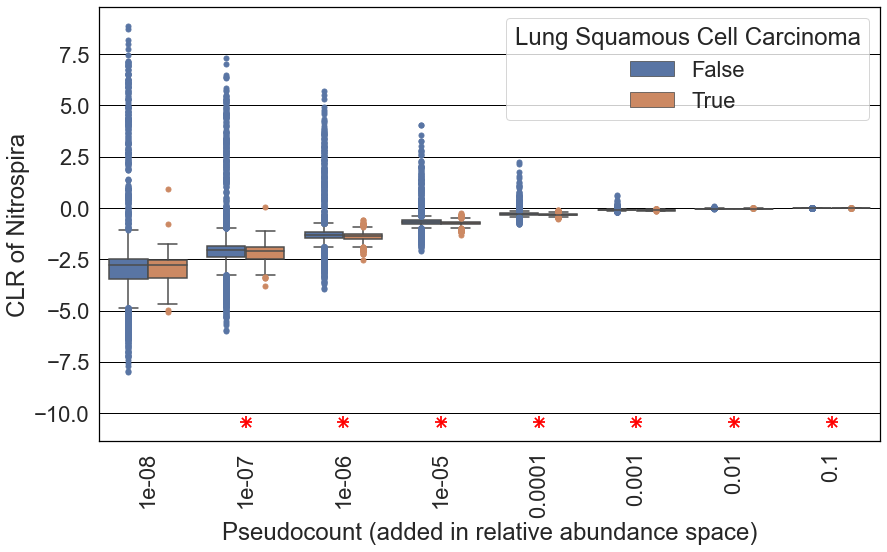

In [14]:
make_pseudocount_boxplot(df,
                         md, 
                         xaxis_name,
                         val, 
                         pval_thresh=0.01)
plt.title(None)
plt.show()

## fig 5

In [15]:
df = pd.read_csv('Kraken-TCGA-Raw-Data-17625-Samples.csv', index_col=0)
md = pd.read_csv('Metadata-TCGA-All-18116-Samples.csv', index_col=0).loc[df.index]
md=md.loc[(md.primary_site=='Head and Neck')&\
          (md.sample_type.str.contains('Blood')==False)
         ]

md.loc[md.sample_type.str.contains('Metastatic'), 'sample_type'] = 'Primary Tumor'
df=df.loc[df.index.isin(md.index)]
md=md.loc[md.index.isin(df.index)].loc[df.index]
md = md.sort_values('sample_type', ascending=False)
df=df.loc[md.index]


cols = pd.read_csv('Kraken-TCGA-Voom-SNM-Most-Stringent-Filtering-Data.csv', 
                   index_col=0, 
                   nrows=1).columns
df = df.loc[:, cols[cols.str.contains('contaminant')==False]]

md['grouping'] = md.sample_type

val ='k__Viruses.o__Caudovirales.f__Myoviridae.g__Mulikevirus'
save_path = 'supp-plots/Fig-S2f'
# save_path = 'tcga_plots/Fig-5-Head-and-Neck-Mulikevirus'

    pseudocount    pvalue  is_sig     y_val
0  1.000000e-08  0.496254   False -6.427434
1  1.000000e-07  0.445800   False -6.427434
2  1.000000e-06  0.418512   False -6.427434
3  1.000000e-05  0.450076   False -6.427434
4  1.000000e-04  0.478558   False -6.427434
5  1.000000e-03  0.385505   False -6.427434
6  1.000000e-02  0.439509   False -6.427434
7  1.000000e-01  0.133526   False -6.427434
    pseudocount    pvalue  is_sig     y_val
0  1.000000e-08  0.496254   False -6.427434
1  1.000000e-07  0.445800   False -6.427434
2  1.000000e-06  0.418512   False -6.427434
3  1.000000e-05  0.450076   False -6.427434
4  1.000000e-04  0.478558   False -6.427434
5  1.000000e-03  0.385505   False -6.427434
6  1.000000e-02  0.439509   False -6.427434
7  1.000000e-01  0.133526   False -6.427434


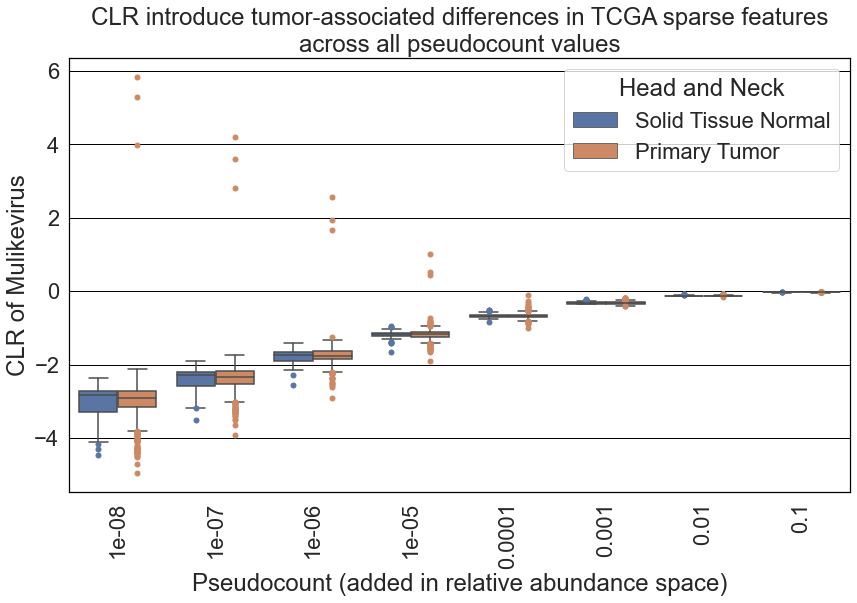

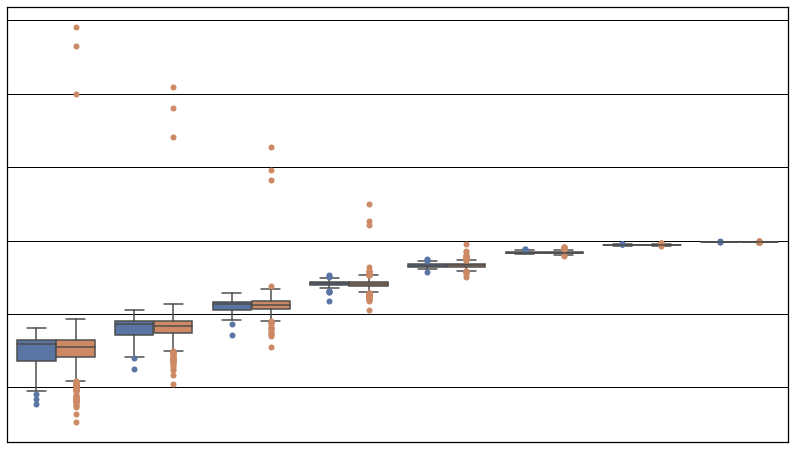

In [16]:
ax=make_pseudocount_boxplot(df,
                         md, 
                         'Head and Neck',
                         val,
                         pval_thresh=0.01
                         )


plt.savefig(save_path+'.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
            )

ax=make_pseudocount_boxplot(df,
                         md, 
                         'Head and Neck',
                         val,
                         pval_thresh=0.01
                         )


ax.get_legend().remove()
ax.set(
       yticklabels=[], 
       xticklabels=[])
plt.xlabel(None)
plt.ylabel(None)
plt.title(None)
plt.savefig(save_path+'-no-axes.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
            )

    pseudocount    pvalue  is_sig     y_val
0  1.000000e-08  0.496254   False -6.427434
1  1.000000e-07  0.445800   False -6.427434
2  1.000000e-06  0.418512   False -6.427434
3  1.000000e-05  0.450076   False -6.427434
4  1.000000e-04  0.478558   False -6.427434
5  1.000000e-03  0.385505   False -6.427434
6  1.000000e-02  0.439509   False -6.427434
7  1.000000e-01  0.133526   False -6.427434


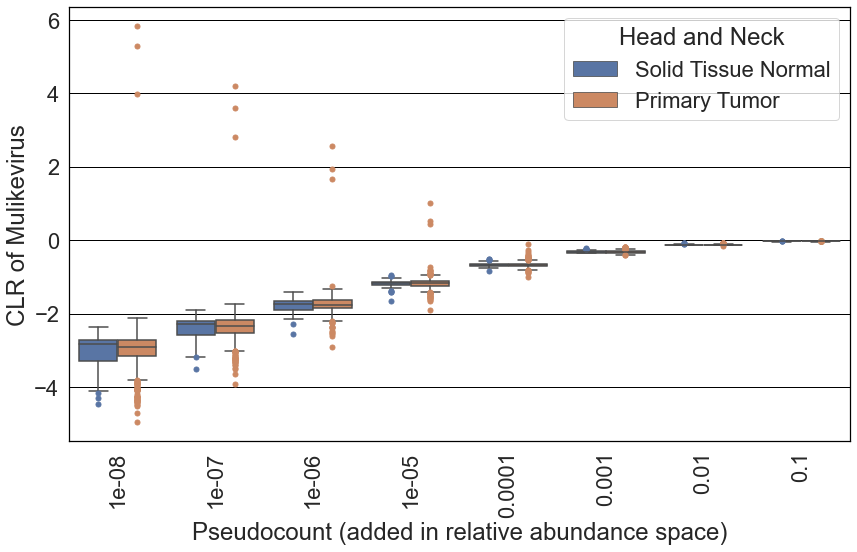

In [17]:
make_pseudocount_boxplot(df,
                         md, 
                         'Head and Neck',
                         val,
                         pval_thresh=0.01
                         )
plt.title(None)
plt.show()